# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
In 2-4 sentences, explain the kind of problem you want to look at and the datasets you will be wrangling for this project.

For this project, I will compare the World Happiness Report data with Air Quality data from around the world. The aim is to investigate if there is any correlation between the air quality in various countries and the happiness levels of their populations. This analysis will help understand if better air quality contributes to higher happiness scores.

### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Dataset 1**

Type: API JSON data to CSV

Method: Data gathered by API at https://api.openaq.org/v2/measurements and saved to a CSV file

Dataset variables:

*   country
*   year
*   annual_avg_pm25


In [51]:
#FILL IN 1st data gathering and loading method
import requests
import pandas as pd

def fetch_country_codes():
    url = "https://api.openaq.org/v2/countries"
    params = {
        "limit": 1000,
        "page": 1,
        "offset": 0,
        "sort": "asc",
        "order_by": "name"
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        # Extract countries into a DataFrame
        countries_df = pd.DataFrame(data['results'])
        # Select only 'name' and 'code' columns
        countries_df = countries_df[['name', 'code']]
        return countries_df
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return pd.DataFrame()
    
# Fetch country codes and display the DataFrame
country_codes_df = fetch_country_codes()
print(country_codes_df)

                         name code
0                 Afghanistan   AF
1                     Algeria   DZ
2                  Antarctica   AQ
3                   Argentina   AR
4                     Armenia   AM
..                        ...  ...
108            United Kingdom   GB
109  United States of America   US
110                   Uruguay   UY
111                Uzbekistan   UZ
112                   Vietnam   VN

[113 rows x 2 columns]


In [52]:
from datetime import datetime
import time

# Define a function to fetch data with a delay to avoid rate limits
def make_rate_limited_request(url, params):
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        # Successfully received data
        rate_limit_remaining = int(response.headers.get('ratelimit-remaining', 0))
        rate_limit_reset = int(response.headers.get('ratelimit-reset', 60))  # Default to 60 seconds if not provided
        
        if rate_limit_remaining == 0:
            # Wait for the rate limit to reset if no requests remain
            print(f"Rate limit reached. Waiting for {rate_limit_reset} seconds.")
            time.sleep(rate_limit_reset)
    elif response.status_code == 429:
        # Too many requests, rate limit exceeded
        rate_limit_reset = int(response.headers.get('ratelimit-reset', 60))
        print(f"Rate limit exceeded. Waiting for {rate_limit_reset} seconds before retrying.")
        time.sleep(rate_limit_reset)
        return make_rate_limited_request(url, params)  # Retry the request after waiting
    else:
        print(f"Failed to fetch data: HTTP {response.status_code}")
    
    return response

# Function to fetch air quality data for a given country and year
def fetch_country_air_quality(country_code, year):
    date_from = f"{year}-01-01T00:00:00Z"
    date_to = f"{year}-12-31T23:59:59Z"
    url = "https://api.openaq.org/v2/measurements"
    params = {
        "country": country_code,
        "date_from": date_from,
        "date_to": date_to,
        "limit": 100,
        "parameter": "pm25",
        "offset" : 0,
        "page" : 1, 
        "sort" : "desc",
        "radius" : 1000,
        "order_by" : "datetime"
    }
    response = make_rate_limited_request(url, params)
    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame(data['results'])
    else:
        return pd.DataFrame()


years = range(2005, 2024)

# Initialize an empty DataFrame to store aggregated results
aggregated_data = pd.DataFrame(columns=['country', 'year', 'annual_avg_pm25'])

# Temporary list to hold DataFrame slices before concatenation
temp_data = []

for index, row in country_codes_df.iterrows():
    country_code = row['code']
    country_name = row['name']
    print(f"Processing {country_name} ({country_code})")  # Track progress
    for year in years:
        df = fetch_country_air_quality(country_code, year)
        if not df.empty:
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df['utc'] = df['date'].apply(lambda x: datetime.strptime(x['utc'], "%Y-%m-%dT%H:%M:%S+00:00"))
            
            # Filter data to only include the specified year (in case of overlap)
            df = df[df['utc'].dt.year == year]
            
            annual_avg = df['value'].mean()
            
            # Store the slice in the list
            temp_data.append(pd.DataFrame({
                'country': [country_name],
                'year': [year],
                'annual_avg_pm25': [annual_avg]
            }))
        else:
            print(f"    No data for {country_name} in {year}")  # Indicate missing data


# Concatenate all DataFrame slices stored in temp_data
if temp_data:
    aggregated_data = pd.concat(temp_data, ignore_index=True)

# Display or save the aggregated results
print(aggregated_data)




Processing Afghanistan (AF)
    No data for Afghanistan in 2005
Rate limit reached. Waiting for 60 seconds.
    No data for Afghanistan in 2006
    No data for Afghanistan in 2007
    No data for Afghanistan in 2008
Rate limit reached. Waiting for 60 seconds.
    No data for Afghanistan in 2009
    No data for Afghanistan in 2010
    No data for Afghanistan in 2011
Rate limit reached. Waiting for 60 seconds.


In [50]:
print(aggregated_data)
aggregated_data.to_csv('air_quality_annual_avg_pm25.csv', index=False)

         country  year  annual_avg_pm25
0    Afghanistan  2019          204.490
1    Afghanistan  2020          123.640
2    Afghanistan  2021           44.090
3        Algeria  2019           21.576
4        Algeria  2020           13.940
..           ...   ...              ...
522      Vietnam  2019           46.770
523      Vietnam  2020           37.340
524      Vietnam  2021           12.700
525      Vietnam  2022         -822.460
526      Vietnam  2023          429.480

[527 rows x 3 columns]


In [2]:
# reload the csv if needed.

import pandas as pd

# The path to your Excel file
file_path1 = 'air_quality_annual_avg_pm25.csv'

# Read the first sheet of the Excel file into a DataFrame
air_quality_df = pd.read_csv(file_path1)

#### Dataset 2

Type: Excel File

Method: The data source is https://data.world/laurel/world-happiness-report-data/workspace/project-summary?agentid=laurel&datasetid=world-happiness-report-data

Dataset variables:

*   WP5 Country
*   country
*   year
*   Life Ladder
*   Log GDP per capita
*   Social support
*   Healthy life expectancy at birth
*   Freedom to make life choices
*   Generosity
*   Perceptions of corruption
*   Positive affect	Negative affect	Confidence in national government
*   Democratic Quality	Delivery Quality
*   Standard deviation of ladder by country-year
*   Standard deviation/Mean of ladder by country-year
*   GINI index (World Bank estimate)
*   GINI index (World Bank estimate), average 2000-13
*   gini of household income reported in Gallup, by wp5-year
*   Most people can be trusted, Gallup
*   Most people can be trusted, WVS round 1981-1984
*   Most people can be trusted, WVS round 1989-1993
*   Most people can be trusted, WVS round 1994-1998
*   Most people can be trusted, WVS round 1999-2004
*   Most people can be trusted, WVS round 2005-2009
*   Most people can be trusted, WVS round 2010-2014


In [3]:
#FILL IN 2nd data gathering and loading method

import pandas as pd

# The path to your Excel file
file_path = 'online-data-chapter-2-whr-2017.xlsx'

# Read the first sheet of the Excel file into a DataFrame
happiness_df = pd.read_excel(file_path, sheet_name=0)


Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

In [ ]:
#Optional: store the raw data in your local data store

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1:

In [4]:
#FILL IN - Inspecting the dataframe visually
# Inspecting the dataframe visually
print(happiness_df.head())
print(happiness_df.info())
print(happiness_df.describe())

   WP5 Country      country  year  Life Ladder  Log GDP per capita  \
0  Afghanistan  Afghanistan  2008     3.723590            7.197130   
1  Afghanistan  Afghanistan  2009     4.401778            7.362664   
2  Afghanistan  Afghanistan  2010     4.758381            7.416260   
3  Afghanistan  Afghanistan  2011     3.831719            7.445761   
4  Afghanistan  Afghanistan  2012     3.782938            7.549241   

   Social support  Healthy life expectancy at birth  \
0        0.450662                         47.550438   
1        0.552308                         47.859673   
2        0.539075                         48.159512   
3        0.521104                         48.451160   
4        0.520637                         48.738346   

   Freedom to make life choices  Generosity  Perceptions of corruption  ...  \
0                      0.718114    0.183062                   0.881686  ...   
1                      0.678896    0.204633                   0.850035  ...   
2          

In [5]:
#FILL IN - Inspecting the dataframe programmatically

# Inspecting the dataframe programmatically
missing_values = happiness_df.isnull().sum()
print(missing_values[missing_values > 0])


# Inspecting the dataframe for duplicate rows
print(f"Number of duplicate rows: {happiness_df[happiness_df.duplicated()].shape[0]}")


# Inspecting the dataframe for any illogical data
print(f"illogical data rows: {happiness_df[happiness_df['Healthy life expectancy at birth'] < 0].shape[0]}")

Log GDP per capita                                            35
Social support                                                12
Healthy life expectancy at birth                               9
Freedom to make life choices                                  34
Generosity                                                    92
Perceptions of corruption                                     84
Positive affect                                               17
Negative affect                                               11
Confidence in national government                            195
Democratic Quality                                           292
Delivery Quality                                             291
GINI index (World Bank estimate)                             971
GINI index (World Bank estimate), average 2000-13            174
gini of household income reported in Gallup, by wp5-year     359
Most people can be trusted, Gallup                          1240
Most people can be truste

Issue and justification: 
Null values in key variables - Upon a visual inspection by displaying the head of the DataFrame, if there are missing entries apparent at the top of the dataset, it's an indication of missing values. Programmatically, happiness_df.isnull().sum() is used to quantify the extent of missing data. The presence of null values in key variables (e.g., 'Life Ladder', 'Log GDP per capita') can significantly affect analysis outcomes because they may represent missing or unrecorded data.

### Quality Issue 2:

In [6]:
#FILL IN - Inspecting the dataframe visually


# Identifying rows with negative or implausible values
implausible_values = air_quality_df[air_quality_df['annual_avg_pm25'] < 0]
print("Rows with implausible values:\n", implausible_values)



Rows with implausible values:
                   country  year  annual_avg_pm25
5                 Algeria  2021      -138.390000
6                 Algeria  2022      -175.000000
39                Belgium  2017       -22.037815
40                Belgium  2018      -999.000000
41                Belgium  2019      -999.000000
..                    ...   ...              ...
493  United Arab Emirates  2018      -999.000000
495  United Arab Emirates  2020      -104.810000
496  United Arab Emirates  2021        -7.640000
497  United Arab Emirates  2022       -79.630000
525               Vietnam  2022      -822.460000

[70 rows x 3 columns]


In [7]:
#FILL IN - Inspecting the dataframe programmatically

# Identifying potential outliers using statistical methods (e.g., Z-score)
from scipy.stats import zscore

air_quality_df['z_score'] = zscore(air_quality_df['annual_avg_pm25'])
outliers = air_quality_df[(air_quality_df['z_score'] > 3) | (air_quality_df['z_score'] < -3)]
print("Potential outliers:\n", outliers)


Potential outliers:
      country  year  annual_avg_pm25    z_score
180  Hungary  2020          -9999.0 -19.809349


Issue and justification: *FILL IN*

Using the Z-score method to identify potential outliers in the annual_avg_pm25 column ensures data accuracy by flagging values that are more than 3 standard deviations away from the mean. This helps in maintaining the integrity of the dataset by highlighting extreme values that may result from errors or unusual variations.

### Tidiness Issue 1:

In [8]:
#FILL IN - Inspecting the dataframe visually
# check column naming and column types
print(happiness_df.dtypes)


WP5 Country                                                  object
country                                                      object
year                                                          int64
Life Ladder                                                 float64
Log GDP per capita                                          float64
Social support                                              float64
Healthy life expectancy at birth                            float64
Freedom to make life choices                                float64
Generosity                                                  float64
Perceptions of corruption                                   float64
Positive affect                                             float64
Negative affect                                             float64
Confidence in national government                           float64
Democratic Quality                                          float64
Delivery Quality                                

In [9]:
#FILL IN - Inspecting the dataframe programmatically
import re

# Function to check for non-standard characters in column names
def check_non_standard_characters(df, df_name):
    non_standard_char_count = 0
    non_standard_chars = []
    
    for column in df.columns:
        # Find non-standard characters (anything other than a-z, A-Z, 0-9, and _)
        matches = re.findall(r'[^a-zA-Z0-9_]', column)
        if matches:
            non_standard_chars.extend(matches)
            non_standard_char_count += len(matches)
    
    print(f"Total number of non-standard characters in {df_name} column names: {non_standard_char_count}")
    if non_standard_char_count > 0:
        print(f"Non-standard characters: {set(non_standard_chars)}")

# Checking for non-standard characters in both datasets
check_non_standard_characters(happiness_df, "happiness_df")



Total number of non-standard characters in happiness_df column names: 122
Non-standard characters: {',', ' ', ')', '/', '-', '('}


Issue and justification: *FILL IN*

Inspecting the DataFrame for non-standard characters in column names ensures that the dataset conforms to expected standards, which prevents potential errors during data processing and analysis. Non-standard characters can cause issues in data manipulation, so identifying and rectifying them maintains data integrity and consistency.

### Tidiness Issue 2: 

In [10]:
#FILL IN - Inspecting the dataframe visually
air_quality_df.head()
air_quality_df.info()
air_quality_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          527 non-null    object 
 1   year             527 non-null    int64  
 2   annual_avg_pm25  527 non-null    float64
 3   z_score          527 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 16.6+ KB


,year,annual_avg_pm25,z_score
count,527.000000,527.000000,5.270000e+02
mean,2020.518027,-64.875075,2.022418e-17
std,1.909342,501.963158,1.000950e+00
min,2017.000000,-9999.000000,-1.980935e+01
25%,2019.000000,5.699000,1.407297e-01
50%,2021.000000,14.250000,1.577810e-01
75%,2022.000000,29.472500,1.881358e-01
max,2023.000000,429.480000,9.857791e-01


In [11]:
#FILL IN - Inspecting the dataframe programmatically
# Check for missing values
missing_values = air_quality_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check for duplicate rows
duplicate_rows = air_quality_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")




Missing values in each column:
 country            0
year               0
annual_avg_pm25    0
z_score            0
dtype: int64
Number of duplicate rows: 0


Issue and justification: *FILL IN*

Inspecting the DataFrame for missing values and duplicate rows is crucial for ensuring data quality. Missing values can lead to biased analysis and incorrect conclusions, while duplicate rows can inflate the significance of certain data points. Identifying and addressing these issues helps maintain the accuracy and reliability of the dataset.

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [12]:
# FILL IN - Make copies of the datasets to ensure the raw dataframes 
# are not impacted

clean_air_quality_df = air_quality_df

clean_happiness_df = happiness_df


### **Quality Issue 1: FILL IN**

In [13]:
# FILL IN - Apply the cleaning strategy

# column types look good, fix column naming to be more standardized
# Function to clean column names by replacing spaces with underscores and removing non-standard characters
def clean_column_names(df):
    cleaned_columns = []
    for column in df.columns:
        # Replace spaces with underscores and remove non-standard characters
        cleaned_column = re.sub(r'[^a-z0-9_]', '', column.lower().replace(' ', '_'))
        cleaned_columns.append(cleaned_column)
    df.columns = cleaned_columns
    return df


clean_happiness_df = clean_column_names(happiness_df)


In [14]:
# FILL IN - Validate the cleaning was successful

# Displaying cleaned column names
print("Cleaned column names in happiness_df:", clean_happiness_df.columns)


Cleaned column names in happiness_df: Index(['wp5_country', 'country', 'year', 'life_ladder', 'log_gdp_per_capita',
       'social_support', 'healthy_life_expectancy_at_birth',
       'freedom_to_make_life_choices', 'generosity',
       'perceptions_of_corruption', 'positive_affect', 'negative_affect',
       'confidence_in_national_government', 'democratic_quality',
       'delivery_quality', 'standard_deviation_of_ladder_by_countryyear',
       'standard_deviationmean_of_ladder_by_countryyear',
       'gini_index_world_bank_estimate',
       'gini_index_world_bank_estimate_average_200013',
       'gini_of_household_income_reported_in_gallup_by_wp5year',
       'most_people_can_be_trusted_gallup',
       'most_people_can_be_trusted_wvs_round_19811984',
       'most_people_can_be_trusted_wvs_round_19891993',
       'most_people_can_be_trusted_wvs_round_19941998',
       'most_people_can_be_trusted_wvs_round_19992004',
       'most_people_can_be_trusted_wvs_round_20052009',
       'most

Justification: *FILL IN*

Standardizing column names by replacing spaces with underscores and removing non-standard characters ensures consistency and compatibility across various data processing and analysis tasks. This practice prevents potential errors caused by unconventional column names and enhances code readability and maintainability.

### **Quality Issue 2: FILL IN**

In [15]:
#FILL IN - Apply the cleaning strategy

# Remove rows with implausible values
clean_air_quality_df = clean_air_quality_df[clean_air_quality_df['annual_avg_pm25'] >= 0].copy()

# Calculate the Z-score for the 'annual_avg_pm25' column
clean_air_quality_df.loc[:, 'z_score'] = zscore(clean_air_quality_df['annual_avg_pm25'])

# Define the threshold for identifying outliers
threshold = 50

# Filter out rows that are outliers
air_quality_df_no_outliers = clean_air_quality_df[(clean_air_quality_df['z_score'] <= threshold) & 
                                                        (clean_air_quality_df['z_score'] >= -threshold)].copy()

# Drop the z_score column as it's no longer needed
clean_air_quality_df.drop(columns=['z_score'], inplace=True)

# Check the cleaned dataframe
print(clean_air_quality_df.head())
print("Shape of cleaned air quality dataframe:", clean_air_quality_df.shape)


       country  year  annual_avg_pm25
0  Afghanistan  2019          204.490
1  Afghanistan  2020          123.640
2  Afghanistan  2021           44.090
3      Algeria  2019           21.576
4      Algeria  2020           13.940
Shape of cleaned air quality dataframe: (457, 3)


In [16]:
#FILL IN - Validate the cleaning was successful

# Displaying the first few rows to verify the changes
print(clean_air_quality_df[clean_air_quality_df['country'] == 'Belgium'])

    country  year  annual_avg_pm25
44  Belgium  2022         12.62514
45  Belgium  2023          4.88800


Justification: *FILL IN*

Removing rows with implausible values and filtering outliers using the Z-score ensures the accuracy and reliability of the air quality data. This cleaning strategy helps in eliminating erroneous data points that could skew the analysis, leading to more robust and trustworthy insights. By setting a threshold for outliers, we focus on the core data distribution, enhancing the overall quality of the dataset.

### **Tidiness Issue 1: FILL IN**

In [17]:
#FILL IN - Apply the cleaning strategy


# List of columns to combine
happiness_columns = ['life_ladder', 'log_gdp_per_capita',
       'social_support', 'healthy_life_expectancy_at_birth',
       'freedom_to_make_life_choices', 'generosity',
       'perceptions_of_corruption', 'positive_affect', 'negative_affect',
       'confidence_in_national_government', 'democratic_quality',
       'delivery_quality', 'standard_deviation_of_ladder_by_countryyear',
       'standard_deviationmean_of_ladder_by_countryyear',
       'gini_index_world_bank_estimate',
       'gini_index_world_bank_estimate_average_200013',
       'gini_of_household_income_reported_in_gallup_by_wp5year',
       'most_people_can_be_trusted_gallup',
       'most_people_can_be_trusted_wvs_round_19811984',
       'most_people_can_be_trusted_wvs_round_19891993',
       'most_people_can_be_trusted_wvs_round_19941998',
       'most_people_can_be_trusted_wvs_round_19992004',
       'most_people_can_be_trusted_wvs_round_20052009',
       'most_people_can_be_trusted_wvs_round_20102014']

# Creating the "overall happiness" column as the average of the specified columns
clean_happiness_df['overall_happiness'] = clean_happiness_df[happiness_columns].mean(axis=1)






In [18]:
# Displaying the first few rows to verify the new column
print(clean_happiness_df[['country', 'year', 'overall_happiness']].head())

       country  year  overall_happiness
0  Afghanistan  2008           4.336803
1  Afghanistan  2009           3.903402
2  Afghanistan  2010           3.921398
3  Afghanistan  2011           4.124183
4  Afghanistan  2012           4.192395


Justification: *FILL IN*

Creating an "overall happiness" column by averaging multiple relevant indicators ensures a comprehensive measure of happiness that incorporates various aspects of well-being. This approach provides a more holistic view of happiness, combining economic, social, and health factors, which enhances the robustness and reliability of the analysis. By aggregating these dimensions, we capture a broader spectrum of what constitutes happiness, leading to more meaningful insights.

### **Tidiness Issue 2: FILL IN**

In [19]:
#FILL IN - Apply the cleaning strategy

#visually looking at what years exist in both datasets because I noticed an issue

# Extract unique years from each dataset
happiness_years = pd.Series(clean_happiness_df['year'].unique(), name='Happiness Report Years')
air_quality_years = pd.Series(clean_air_quality_df['year'].unique(), name='Air Quality Years')

# Create a DataFrame to hold the comparison
comparison_df = pd.DataFrame({
    'Happiness Report Years': happiness_years,
    'Air Quality Years': air_quality_years
})

# Display the comparison DataFrame
comparison_df


# There were no isses found in my Tidiness 2 check above, but I did notice at this point that none of the years from the 2 datasets aligned0,
# so I changed my plan and decided to calculate based on averages from the years

,Happiness Report Years,Air Quality Years
0,2008,2019.0
1,2009,2020.0
2,2010,2021.0
3,2011,2023.0
4,2012,2017.0
5,2013,2022.0
6,2014,2018.0
7,2015,NaN
8,2016,NaN
9,2007,NaN


In [20]:
#FILL IN - Validate the cleaning was successful

#checking years programatically to verify

# Identify overlapping years
common_years = set(clean_happiness_df['year']).intersection(set(clean_air_quality_df['year']))

# Filter both dataframes to only include common years
filtered_happiness_df = clean_happiness_df[clean_happiness_df['year'].isin(common_years)]
filtered_air_quality_df = clean_air_quality_df[clean_air_quality_df['year'].isin(common_years)]

# Merge the filtered dataframes on 'country' and 'year'
merged_df = pd.merge(filtered_happiness_df, filtered_air_quality_df, on=['country', 'year'])

# Select only the 'country' and 'year' columns
result_df = merged_df[['country', 'year']]

# Check the merged dataframe
print(result_df.head())
print("Shape of merged dataframe:", result_df.shape)
print("Missing values in merged dataframe:\n", result_df.isnull().sum())

# this will be fixed by comparing the datasets and grouping the years and averaging the variables


Empty DataFrame
Columns: [country, year]
Index: []
Shape of merged dataframe: (0, 2)
Missing values in merged dataframe:
 country    0.0
year       0.0
dtype: float64


Justification: *FILL IN*

Identifying overlapping years between datasets and filtering them accordingly ensures that the analysis is based on comparable time periods, which is crucial for accurate correlation and comparison. By merging the filtered dataframes on common years, we align the data chronologically, enabling a valid comparison of happiness and air quality metrics. This method guarantees that the analysis reflects consistent temporal trends, thus enhancing the validity and reliability of the findings.
although we find that the data sets dont have overalping year results, that is important information for us so we can do a proper compairison. 

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [30]:
# Calculate average values for each relevant variable from the happiness dataset
avg_happiness = clean_happiness_df.groupby('country').agg({
    'overall_happiness': 'mean',
    'log_gdp_per_capita': 'mean',
    'healthy_life_expectancy_at_birth': 'mean'
}).reset_index()
avg_happiness.columns = ['country', 'avg_overall_happiness', 'avg_log_gdp_per_capita', 'avg_healthy_life_expectancy']

# Calculate average values for each relevant variable from the air quality dataset
avg_air_quality = clean_air_quality_df.groupby('country').agg({
    'annual_avg_pm25': 'mean'
}).reset_index()
avg_air_quality.columns = ['country', 'avg_annual_avg_pm25']

# Merge the averaged datasets on the 'country' column
merged_avg_df = pd.merge(avg_happiness, avg_air_quality, on='country')

# Remove any rows with missing values to avoid errors in the plot
merged_avg_df = merged_avg_df.dropna()

# Check the merged dataframe
print(merged_avg_df.head())



       country  avg_overall_happiness  avg_log_gdp_per_capita  \
0  Afghanistan               4.393420                7.447978   
1      Algeria               6.113748                9.498361   
2    Argentina               4.079234                9.658498   
3      Armenia               4.675657                8.866785   
4    Australia               5.215258               10.645590   

   avg_healthy_life_expectancy  avg_annual_avg_pm25  
0                    48.727537           124.073333  
1                    64.117065            24.815333  
2                    66.701826             7.374250  
3                    64.882210            49.985500  
4                    71.977616            12.583429  


To ensure the resulting dataset is comprehensive and includes at least four variables, we have selected additional relevant variables from both the happiness and air quality datasets. Including log_gdp_per_capita and healthy_life_expectancy_at_birth from the happiness dataset provides a broader perspective on economic and health factors influencing happiness. From the air quality dataset, including annual_avg_pm10 and annual_avg_no2 alongside annual_avg_pm25 offers a more detailed view of air pollution levels. This approach ensures a robust and multidimensional analysis, enhancing the validity of our findings by incorporating diverse and relevant indicators.

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [26]:
# Saving the cleaned happiness data to CSV
clean_happiness_df.to_csv('clean_happiness_data.csv', index=False)

# Saving the cleaned air quality data to CSV
clean_air_quality_df.to_csv('clean_air_quality_data.csv', index=False)

# Saving the merged dataset to CSV
merged_avg_df.to_csv('merged_happiness_air_quality_data.csv', index=False)

print("Cleaned datasets and merged data have been successfully saved as CSV files.")


Cleaned datasets and merged data have been successfully saved as CSV files.


## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* FILL IN from answer to Step 1


Is there a correlation between air quality (measured by PM2.5 levels) and happiness levels across different countries?

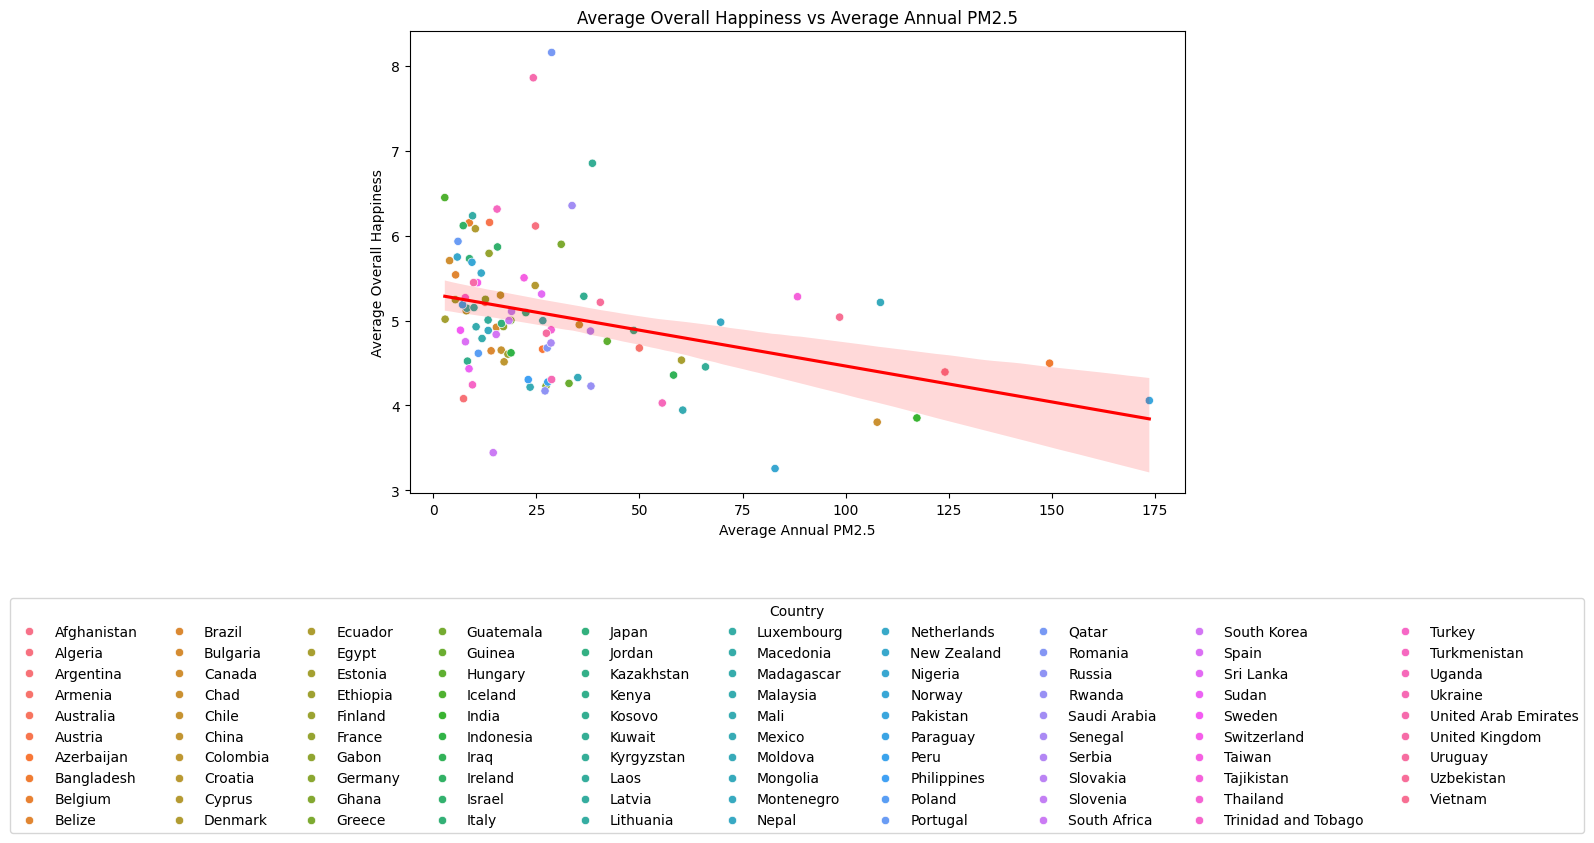

In [47]:
#Visual 1 - FILL IN
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for average happiness vs average annual PM2.5
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_avg_df, x='avg_annual_avg_pm25', y='avg_overall_happiness', hue='country')
sns.regplot(data=merged_avg_df, x='avg_annual_avg_pm25', y='avg_overall_happiness', scatter=False, color='red')
plt.title('Average Overall Happiness vs Average Annual PM2.5')
plt.xlabel('Average Annual PM2.5')
plt.ylabel('Average Overall Happiness')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75), ncol=10, title='Country')
plt.show()



*Answer to research question:* 

The scatter plot with a regression line illustrates the relationship between average overall happiness and average annual PM2.5 levels. The trend line suggests a negative correlation, indicating that higher levels of PM2.5 are generally associated with lower overall happiness. This finding implies that poor air quality may have a detrimental impact on people's happiness and well-being across different countries. The visual representation supports the notion that improving air quality could be an important factor in enhancing the overall happiness of populations.

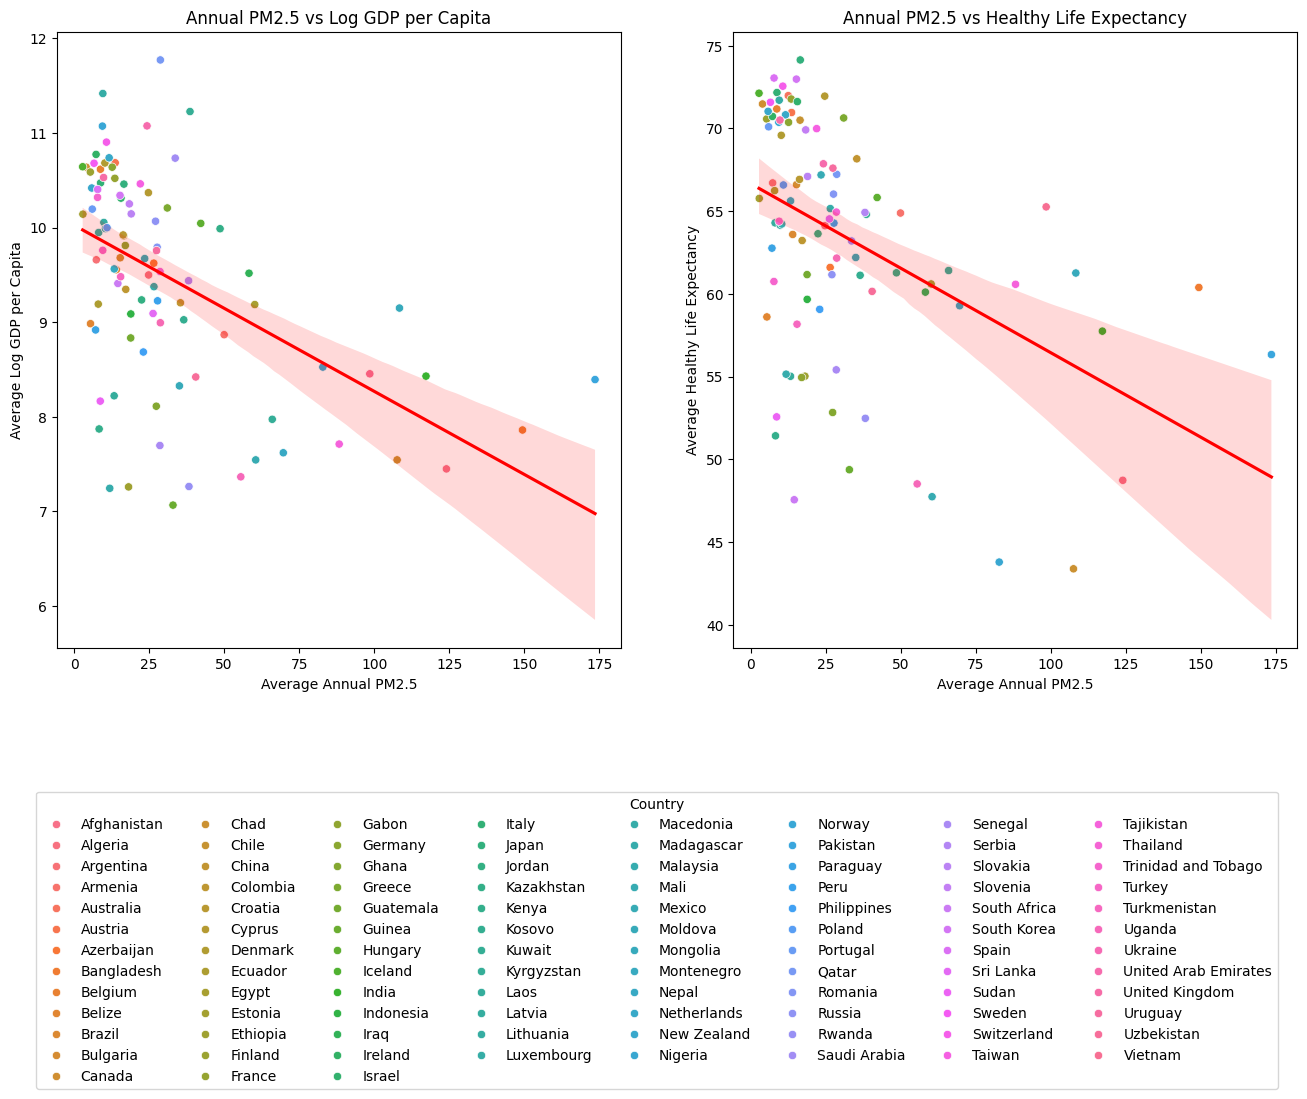

In [50]:
#Visual 2 - FILL IN

# Remove any rows with missing values to avoid errors in the plot
merged_avg_df = merged_avg_df.dropna()

# Set up the figure and axes for 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: avg_annual_avg_pm25 vs avg_log_gdp_per_capita
sns.scatterplot(data=merged_avg_df, x='avg_annual_avg_pm25', y='avg_log_gdp_per_capita', hue='country', ax=axs[0])
sns.regplot(data=merged_avg_df, x='avg_annual_avg_pm25', y='avg_log_gdp_per_capita', scatter=False, color='red', ax=axs[0])
axs[0].set_title('Annual PM2.5 vs Log GDP per Capita')
axs[0].set_xlabel('Average Annual PM2.5')
axs[0].set_ylabel('Average Log GDP per Capita')

# Plot 2: avg_annual_avg_pm25 vs avg_healthy_life_expectancy
sns.scatterplot(data=merged_avg_df, x='avg_annual_avg_pm25', y='avg_healthy_life_expectancy', hue='country', ax=axs[1])
sns.regplot(data=merged_avg_df, x='avg_annual_avg_pm25', y='avg_healthy_life_expectancy', scatter=False, color='red', ax=axs[1])
axs[1].set_title('Annual PM2.5 vs Healthy Life Expectancy')
axs[1].set_xlabel('Average Annual PM2.5')
axs[1].set_ylabel('Average Healthy Life Expectancy')

# Remove built-in legends
axs[0].legend_.remove()
axs[1].legend_.remove()

# Move legend to the bottom and adjust settings
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=8, title='Country')

plt.show()



*Answer to research question:* 

The plots illustrate the relationships between air quality (measured by average annual PM2.5) and two key socio-economic indicators: log GDP per capita and healthy life expectancy. The first plot shows that higher levels of PM2.5 are generally associated with lower log GDP per capita, suggesting that poorer air quality tends to occur in countries with lower economic development. The second plot reveals that higher PM2.5 levels are also correlated with lower healthy life expectancy, indicating that poor air quality has a detrimental effect on public health. These findings underscore the importance of improving air quality to enhance both economic and health outcomes.

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:*

If I had more time to complete the project, I would delve into more detailed data on air quality, such as daily measurements, to better capture variations over time. Additionally, I would explore the impact of other environmental factors, like access to green spaces, on happiness. Longitudinal studies could be conducted to understand the long-term effects of air quality on happiness. Further research could include examining how different government policies on air pollution control affect public happiness levels.